In [2]:
import re
import string
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
## subset can be all train test
data = fetch_20newsgroups(subset='all')

In [4]:
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [5]:
len(data['target']), len(data['data'])

(18846, 18846)

In [6]:
dnews = pd.DataFrame(data = {'text': data['data'], 'target': data['target']})

In [10]:
target_count = dnews.target.value_counts().reset_index()

In [13]:
def map_names(target):
    target_names = data['target_names']
    return target_names[target]

In [15]:
target_count['names'] = target_count.index.map(map_names)

In [17]:
target_count.index = [target_count['names']]

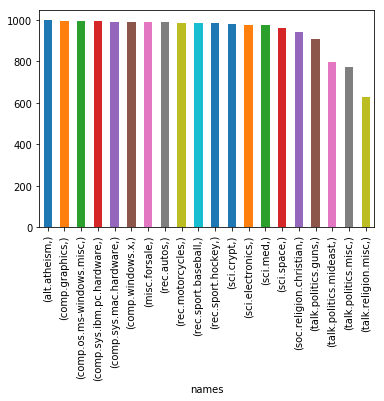

In [28]:
target_count.target.plot(kind='bar')
plt.savefig('class-distribution.png')

## cleansing

In [30]:
def cleansing_text(text):
    text = text.lower()
    text.replace('\n', ' ')
    text.strip()
    
    return text

In [31]:
dnews['text_clean'] = dnews.text.apply(cleansing_text)

## feature extraction

In [32]:
tfidf = TfidfVectorizer(max_features=5000)

In [33]:
text_vector = tfidf.fit_transform(dnews['text_clean'])

## model

In [34]:
k = KFold(n_splits=5)

In [35]:
def get_metrics(y_test, result):
    acc = accuracy_score(y_test, result)
    pre = precision_score(y_test, result, average='macro')
    rec = recall_score(y_test, result, average='macro')
    f1s = f1_score(y_test, result, average='macro')
    
    return {'accuracy': acc, 'precision': pre, 'recall': rec, 'f1score': f1s}

In [36]:
metrics_kfold = []
for train, test in k.split(text_vector, dnews.target):
    X_train, y_train = text_vector[train], dnews.loc[train, 'target']
    X_test, y_test = text_vector[test], dnews.loc[test, 'target']
    
    #Multinomial Naive Bayes
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    result = mnb.predict(X_test)
    metrics = get_metrics(y_test, result)
    metrics_kfold.append(metrics)

## evaluation

In [37]:
dmetrics = pd.DataFrame(metrics_kfold)

In [38]:
dmetrics['kfold'] = ['k' + str(i) for i in list(range(0,5))]

In [39]:
dmetrics

,accuracy,f1score,precision,recall,kfold
0,0.831830,0.818491,0.839549,0.821221,k0
1,0.842399,0.829749,0.855302,0.832051,k1
2,0.847970,0.834753,0.857225,0.835454,k2
3,0.837357,0.826910,0.848825,0.826853,k3
4,0.840807,0.828169,0.852124,0.828847,k4


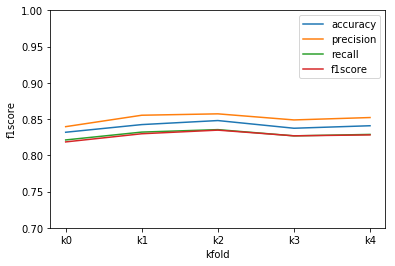

<Figure size 432x288 with 0 Axes>

In [40]:
sns.lineplot(x = 'kfold', y = 'accuracy', data = dmetrics, label='accuracy')
sns.lineplot(x = 'kfold', y = 'precision', data = dmetrics, label='precision')
sns.lineplot(x = 'kfold', y = 'recall', data = dmetrics, label='recall')
sns.lineplot(x = 'kfold', y = 'f1score', data = dmetrics, label='f1score')
plt.ylim(0.7, 1)
plt.show()
plt.savefig('20newsgroup-mnb-tfidf.png')